In [1]:
import dataloader
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
class EEGNet(nn.Module):
    #根據spec架構創建 EEGNet 模型
    def __init__(self, activation = None, dropout=0.25):
        super(EEGNet, self).__init__()
        activation_function = nn.ModuleDict([['ELU', nn.ELU(alpha = 1.0)], ['ReLU', nn.ReLU()], ['LeakyReLU', nn.LeakyReLU()]])

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1,1), padding = (0,25), bias = False ),
            nn.BatchNorm2d(16, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)
        )
        
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = (2,1), stride = (1,1), groups = 16, bias = False ),
            nn.BatchNorm2d(32, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            activation_function[activation],
            nn.AvgPool2d(kernel_size = (1, 4), stride = (1, 4), padding = 0),
            nn.Dropout(p = dropout)
        )
        
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1,1), padding = (0, 7), bias = False
            ),
            nn.BatchNorm2d(32, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            #選擇 activation function
            activation_function[activation],
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p = dropout)
        )
        
        self.classify = nn.Sequential(
            nn.Linear(736, out_features = 2, bias = True)
        )
        
     
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # flatten
        x = x.view(x.size(0), -1)
        output = self.classify(x)
        return output


In [3]:
from functools import reduce

class DeepConvNet(nn.Module):
    def __init__(self, activation=None, deepconv=[25,50,100,200], dropout=0.5):
        super(DeepConvNet, self).__init__()
        activation_function = nn.ModuleDict([['ELU', nn.ELU(alpha = 1.0)], ['ReLU', nn.ReLU()], ['LeakyReLU', nn.LeakyReLU()]])
        
        self.deepconv = deepconv
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size = (1, 5), stride = (1, 1), bias = False),
            nn.Conv2d(25, 25, kernel_size = (2, 1), stride = (1, 1), bias = False),
            nn.BatchNorm2d(25, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            activation_function[activation],
            nn.MaxPool2d(kernel_size = (1, 2)),
            nn.Dropout(p = 0.5)
        )
        
        for idx in range(1, len(deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(deepconv[idx-1], deepconv[idx], kernel_size=(1,5),stride=(1,1), padding=(0,0), bias=False),
                nn.BatchNorm2d(deepconv[idx], eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
                activation_function[activation],
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=dropout)
            ))
        
        
        flatten_size =  deepconv[-1] * reduce(
            lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify = nn.Sequential(
            nn.Linear(8600, 2, bias=True),
        )
    
    def forward(self, x):
        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)
        # flatten
        x = x.view(x.size(0), -1)
        output = self.classify(x)
        return output


In [4]:


def draw(lines,model,title,accline=0): # draw loss curves


    plt.figure()

    for e in range(len(lines)):

        plt.plot(lines[e]['epoch'], lines[e][title], label = lines[e]['name'])

    plt.xlabel('epoch')
    plt.ylabel(title)

    plt.title(title)
    plt.legend()
    
    if accline != 0:
            plt.hlines(accline, 1,len(lines[0][title]), linestyles='--', colors=(0,0,0,0.5))
    plt.savefig(str(model) +"_" +str(title) + ".png")
    plt.show()
    #plt.close()


(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
model: EEGNet, activation: ReLU


epoch: 100
test accuracy: 0.8546296296296296
running_loss: 0.8433207273483276

epoch: 200
test accuracy: 0.862037037037037
running_loss: 0.44696636497974396

epoch: 300
test accuracy: 0.8574074074074074
running_loss: 0.3304850198328495

epoch: 400
test accuracy: 0.8564814814814815
running_loss: 0.21672818437218666

epoch: 500
test accuracy: 0.8731481481481481
running_loss: 0.247467540204525

epoch: 600
test accuracy: 0.8638888888888889
running_loss: 0.17394756246358156

epoch: 700
test accuracy: 0.8564814814814815
running_loss: 0.1905961073935032

epoch: 800
test accuracy: 0.8638888888888889
running_loss: 0.10088546015322208

epoch: 900
test accuracy: 0.8675925925925926
running_loss: 0.07753846328705549

epoch: 1000
test accuracy: 0.8657407407407407
running_loss: 0.11917028855532408

epoch: 1100
test accuracy: 0.8638888888888889
running_loss: 0.19172615464776754

epoch: 1200
test accuracy: 0.865740740

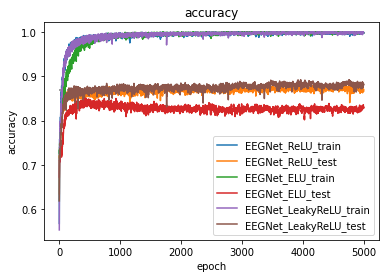

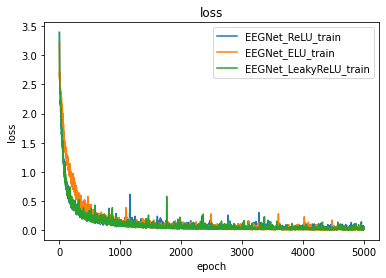

model: DeepConvNet, activation: ReLU


epoch: 100
test accuracy: 0.7907407407407407
running_loss: 1.784300535917282

epoch: 200
test accuracy: 0.8009259259259259
running_loss: 1.343832477927208

epoch: 300
test accuracy: 0.7925925925925926
running_loss: 0.9064788222312927

epoch: 400
test accuracy: 0.8
running_loss: 0.6950652897357941

epoch: 500
test accuracy: 0.7925925925925926
running_loss: 0.6025011092424393

epoch: 600
test accuracy: 0.8046296296296296
running_loss: 0.4847029447555542

epoch: 700
test accuracy: 0.8083333333333333
running_loss: 0.4456583857536316

epoch: 800
test accuracy: 0.8037037037037037
running_loss: 0.4287691116333008

epoch: 900
test accuracy: 0.812962962962963
running_loss: 0.5615418292582035

epoch: 1000
test accuracy: 0.8111111111111111
running_loss: 0.2630024775862694

epoch: 1100
test accuracy: 0.8185185185185185
running_loss: 0.3343729190528393

epoch: 1200
test accuracy: 0.8138888888888889
running_loss: 0.3019263241440058

epoch: 1300
test accuracy: 0

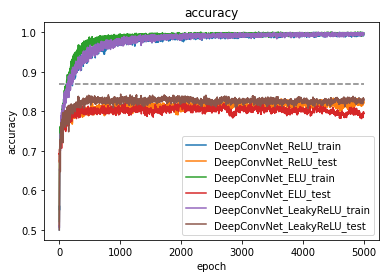

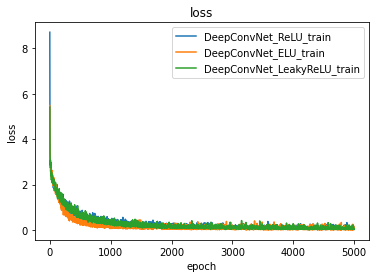

                 ReLU       ELU  LeakyReLU
EEGNet       0.882407  0.851852   0.892593
DeepConvNet  0.834259  0.823148   0.843519
END


In [5]:
if __name__ == '__main__':

   
    # hyperparamaters
    batch_size = 256
    lr = 7e-4
    epochs = 1000
    
    #check if using gpu
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    print("Computer is  using {} to do this lab.  ".format(device))
    
    models = ["EEGNet", "DeepConvNet"] 
    activations = ["ReLU", "ELU", "LeakyReLU"]
    max_dict={"ReLU":[],"ELU":[],"LeakyReLU":[]}
    
    #data prepare
    train_data, train_label, test_data, test_label = dataloader.read_bci_data()
    train_data = torch.tensor(train_data, dtype = torch.float).to(device)
    train_label = torch.tensor(train_label, dtype = torch.long).to(device)
    test_data = torch.tensor(test_data, dtype = torch.float).to(device)
    test_label = torch.tensor(test_label, dtype = torch.long).to(device)
    train_Dataset = Data.TensorDataset(train_data, train_label)
    train_loader = Data.DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    
    # two model
    for model in models:
        line_num = 0
        accuracy = []
        losses = []
            
        #three activation function 
        for activation in activations:
            #create model
            if model == "DeepConvNet":
                Net = DeepConvNet(activation)
            elif model == "EEGNet":
                Net = EEGNet(activation)

            print(f'model: {model}, activation: {activation}\n')
            Net.to(device)
            
            max_acc = 0
            
            Loss = nn.CrossEntropyLoss()
            name = model +"_"+ activation+"_"

            optimizer = optim.Adam(Net.parameters(), lr = lr)
            accuracy.append({'epoch': [], 'accuracy': [], 'name': name + "train"})
            accuracy.append({'epoch': [], 'accuracy': [], 'name': name + "test"})

            losses.append({'epoch': [], 'loss': [], 'name': name + "train"})
            
            #start training
            for epoch in range(1,epochs+1):

                #train
                running_loss = 0.0
                train_correct = 0
                Net.train()
                for (data, label) in train_loader:      
                    optimizer.zero_grad()
                    output = Net(data)
                    predict = output.data.max(1)[1]
                    train_correct += predict.eq(label).cpu().sum().item() #check predict
                    loss = Loss(output, label)
                    running_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                
                
                accuracy[line_num]['epoch'].append(epoch)
                accuracy[line_num]['accuracy'].append(train_correct/len(train_data))

                losses[int(line_num/2)]['epoch'].append(epoch)
                losses[int(line_num/2)]['loss'].append(running_loss)

                #test
                Net.eval()
                with torch.no_grad():
                    test_output = Net(test_data)
                predict = test_output.data.max(1)[1]
                test_correct = predict.eq(test_label).cpu().sum().item() #check predict
                
                #get the max accuracy
                max_acc = max(max_acc,test_correct/len(test_data))

                accuracy[line_num+1]['epoch'].append(epoch)
                accuracy[line_num+1]['accuracy'].append(test_correct/len(test_data))

                #show the accuracy and loss of and check it is still running
                if epoch % 100 == 0 :
                    print(f'\nepoch: {epoch}\ntest accuracy: {test_correct/len(test_data)}')
                    print(f'loss: {running_loss}')

            line_num += 2
            max_dict[activation].append(max_acc)
            print(f'\nmax test accuracy: {max_acc}\n')

        #draw the compare curves
        draw(accuracy,model,"accuracy",0.87)
        draw(losses,model,"loss")
        
    #show all max accuracy by DataFrame
    df = pd.DataFrame(max_dict,index=models)    
    print(df)
    print("END")